# IERG 5350 Assignment 4: Advanced Algorithms for Continuous Control in RL

### Welcome to assignment 4 of our RL course!
*2020-2021 Term 1, IERG 5350: Reinforcement Learning. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao, SUN Hao, ZHAN Xiaohang.*


| Student Name | Student ID |
| :----: | :----: |
| Wanli Wang | 1155160517 |

------


In this assignment, we will implement a system of RL that allows us to train and evaluate RL agents formally and efficiently.

In this notebook, you will go through the following components of the whole system:
- Preparation: Colab, and Environment
- Section 1: Training with algorithm PPO
- Section 2: Training with algorithm DDPG
- Section 3: Training with algorithm TD3
- Section 4: Transfer your PPO/ DDPG/ TD3 to another task: Four-Solution-Maze

The author of this assignment is SUN, Hao (sh018 AT ie.cuhk.edu.hk).

# Colab

### Introduction to Google Colab: 
From now on, our assignment as well as the final project will be based on the Google Colab, where you can apply for free GPU resources to accelerate the learning of your RL models. 

Here are some resources as intro to the Colab.

- YouTube Video: https://www.youtube.com/watch?v=inN8seMm7UI
- Colab Intro: https://colab.research.google.com/notebooks/intro.ipynb
(you may need to login with your google account)




# Gym Continuous Control Tasks

### Introduction to the Gym Continuous Control Envirionments

In the last assignment, you have already used the gym[atari] benchmarks, where the action space is discrete so that normal approach is value-based methods e.g., DQN.

In this assignment, we will try to implement three prevailing RL algorithms for continuous control tasks, namely the PPO(https://arxiv.org/abs/1707.06347), DDPG(https://arxiv.org/abs/1509.02971) and TD3(https://arxiv.org/abs/1802.09477).

We will now begin with a gym environment for continuous control,

The Pendulum-v0






In [13]:
import gym
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
state = env.reset()
print('the state space is like', state)
print('the max and min action is: ',env.action_space.high,env.action_space.low)

'''so that you may need to use action value re-size if you want to use the tanh activation functions'''

the state space is like [-0.25874714 -0.96594509 -0.12174252]
the max and min action is:  [2.] [-2.]


'so that you may need to use action value re-size if you want to use the tanh activation functions'

# PPO 

The Proximal Policy Optimization Algorithms is the most prevailing on-policy learning method. Although its sample efficiency is not as high as the off-policy methods, the PPO is relatively easy to implement and the learning is much more stable than off-policy methods. Whenever you have a task you want to try whether RL works, you may try to run a PPO agent at first. It is worth mentioning even the most challenging game, the StarCraftII agent AlphaStar is trained based on PPO (with lots of improvements, ofcourse).


## TODOs for You
The ppo has the benfitsof trust region policy optimization (TRPO) but is much simpler to implement, and with some implementation engeneering, the sample complexity of TRPO is further improved.

The key idea of PPO optimization is *Not Optimize the Policy Too Much in a Certain Step*, which follows the key insight of the method of TRPO.

In TRPO, the optimization objective of policy is to learn a policy such that 

$$\max_\theta \hat{\mathbb{E}}_t [\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$

subject to 

$$\hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(\cdot|s_t),\pi_\theta(\cdot|s_t)]] \le \delta$$

where $\hat{A}$ denotes the advantage function, rather than optimize the objective function of 

$$L^{PG}(\theta) = \hat{\mathbb{E}}_t[\log \pi_\theta(a_t|s_t)\hat{A}_t]$$

in the normal policy gradint methods.

The PPO proposed two alternative approaches to solve the constrained optimization above, namely the Clipped Surrogated Objective and the Adaptive KL penalty Coefficient. The former one is more generally used in practice as it's more convenient to implement, more efficient and owns stable performance.

The Clipped Surrogated Objective approach replace the surrogate objective

$$L^{CPI}(\theta) = \hat{\mathbb{E}}_t[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}_t[r_t(\theta)\hat{A}_t]$$

of TRPO (CPI: Conservative Policy Iteration) by 

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

You can check that $L^{CLIP}(\theta) = L^{CPI}(\theta)$ around the old policy parameter $\theta_{old}$, i.e., when r = 1.

## TODOs here:

In this section, your task is to finish the code of a PPO algorithm and evaluate its performance in the Pendulum-v0 environment.

Specifically, you need to
- Q1. finish building up the ActorCritic ''\__init__'' function, i.e., build up the neural network.
- Q2. finish the foward function, in this part, there are two functions need to finish: the \_forward_actor function and the \_forward_critic function
- Q3. finish the select_action function, which is called during interacting with the environment, so that you may need to return an action as well as the (log-)probability of getting that action for future optimization
- Q4. finish the optimization steps for your PPO agent, that means you need to build up the surrogate loss through your saved tuples in previous episodes and optimize it with current network parameters.
- Q5. finally, you may need to optimize some of the hyper-parameters to have a better task performance. 

In [14]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = gym.make(ENV_NAME)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    hid_num = 256
    drop_prob = 0.1
    env_name = ENV_NAME
    seed = 1234
    num_episode = 1000
    batch_size = 5120
    max_step_per_round = 2000
    gamma = 0.995
    lamda = 0.97
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 256
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = False
    advantage_norm = True
    lossvalue_norm = True

In [15]:
# You need not to rivese this, these classes are used for normalization
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

In [16]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(num_inputs, 64)
        self.actor_fc2 = nn.Linear(64, 64)
        self.actor_fc3 = nn.Linear(64, num_outputs)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

        self.critic_fc1 = nn.Linear(num_inputs, 64)
        self.critic_fc2 = nn.Linear(64, 64)
        self.critic_fc3 = nn.Linear(64, 1)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        x = torch.tanh(self.actor_fc1(states))
        x = torch.tanh(self.actor_fc2(x))
        action_mean = self.actor_fc3(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''

        x = torch.tanh(self.critic_fc1(states))
        x = torch.tanh(self.critic_fc2(x))
        critic_value = self.critic_fc3(x)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std = torch.exp(action_logstd)
        action = torch.normal(action_mean, action_std)
        if return_logproba:
            logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''

        if std is None:
            std = torch.exp(logstd)

        std_sq = std.pow(2)
        logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)
        return logproba.sum(1)

    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
    env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done, _ = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)

        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()



            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            ratio =  torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
            surr1 = ratio * minibatch_advantages
            surr2 = ratio.clamp(1 - clip_now, 1 + clip_now) * minibatch_advantages
            loss_surr = - torch.mean(torch.min(surr1, surr2))  

            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        args.env_name = envname
        test(args)

#torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_new_{0}hidden_{1}drop_prob_{2}repeat'.format(args.hid_num,config.drop_prob,repeat)) 
#np.savetxt(args.env_name.split('-')[0]+'/Rwds/rwds_new_{0}hidden_{1}drop_prob_{2}repeat'.format(args.hid_num,config.drop_prob,repeat),rwds)

Finished episode: 0 Reward: -1241.0188 total_loss = 93.8050 = 0.0296 + 0.5 * 187.5574 + 0.01 * -0.3292
-----------------
Finished episode: 1 Reward: -1224.5668 total_loss = 76.6035 = -0.1211 + 0.5 * 153.4558 + 0.01 * -0.3230
-----------------
Finished episode: 2 Reward: -1254.0797 total_loss = 90.7226 = 0.0793 + 0.5 * 181.2933 + 0.01 * -0.3356
-----------------
Finished episode: 3 Reward: -1233.3350 total_loss = 76.7953 = -0.0861 + 0.5 * 153.7695 + 0.01 * -0.3289
-----------------
Finished episode: 4 Reward: -1240.8401 total_loss = 91.7659 = 0.1497 + 0.5 * 183.2390 + 0.01 * -0.3306
-----------------
Finished episode: 5 Reward: -1217.0088 total_loss = 76.1486 = 0.0149 + 0.5 * 152.2741 + 0.01 * -0.3287
-----------------
Finished episode: 6 Reward: -1163.9988 total_loss = 79.3931 = 0.1055 + 0.5 * 158.5819 + 0.01 * -0.3340
-----------------
Finished episode: 7 Reward: -1125.8915 total_loss = 66.0185 = -0.0210 + 0.5 * 132.0856 + 0.01 * -0.3299
-----------------
Finished episode: 8 Reward: -

Finished episode: 68 Reward: -1049.4694 total_loss = 23.4393 = 0.0444 + 0.5 * 46.7964 + 0.01 * -0.3285
-----------------
Finished episode: 69 Reward: -1035.3532 total_loss = 20.6979 = -0.0526 + 0.5 * 41.5076 + 0.01 * -0.3312
-----------------
Finished episode: 70 Reward: -1038.2068 total_loss = 19.9933 = -0.1136 + 0.5 * 40.2206 + 0.01 * -0.3347
-----------------
Finished episode: 71 Reward: -1091.7781 total_loss = 23.4858 = 0.0473 + 0.5 * 46.8836 + 0.01 * -0.3303
-----------------
Finished episode: 72 Reward: -1104.8371 total_loss = 24.8251 = 0.0235 + 0.5 * 49.6100 + 0.01 * -0.3315
-----------------
Finished episode: 73 Reward: -1047.6178 total_loss = 20.4546 = -0.0250 + 0.5 * 40.9658 + 0.01 * -0.3278
-----------------
Finished episode: 74 Reward: -1049.2467 total_loss = 20.3534 = 0.0785 + 0.5 * 40.5566 + 0.01 * -0.3398
-----------------
Finished episode: 75 Reward: -1012.1580 total_loss = 18.5902 = -0.0758 + 0.5 * 37.3386 + 0.01 * -0.3298
-----------------
Finished episode: 76 Reward:

Finished episode: 136 Reward: -1194.9264 total_loss = 15.0240 = -0.0294 + 0.5 * 30.1132 + 0.01 * -0.3199
-----------------
Finished episode: 137 Reward: -1195.4477 total_loss = 15.1177 = 0.0332 + 0.5 * 30.1753 + 0.01 * -0.3211
-----------------
Finished episode: 138 Reward: -1183.9406 total_loss = 14.7316 = 0.0925 + 0.5 * 29.2846 + 0.01 * -0.3202
-----------------
Finished episode: 139 Reward: -1174.3701 total_loss = 16.1326 = 0.0089 + 0.5 * 32.2538 + 0.01 * -0.3202
-----------------
Finished episode: 140 Reward: -1147.4754 total_loss = 15.7741 = 0.0626 + 0.5 * 31.4295 + 0.01 * -0.3211
-----------------
Finished episode: 141 Reward: -1153.2143 total_loss = 15.0316 = 0.0190 + 0.5 * 30.0317 + 0.01 * -0.3232
-----------------
Finished episode: 142 Reward: -1129.9464 total_loss = 15.4042 = -0.0040 + 0.5 * 30.8228 + 0.01 * -0.3127
-----------------
Finished episode: 143 Reward: -1147.3170 total_loss = 16.0924 = 0.0278 + 0.5 * 32.1355 + 0.01 * -0.3157
-----------------
Finished episode: 144 

Finished episode: 203 Reward: -1252.5492 total_loss = 16.5717 = -0.0196 + 0.5 * 33.1876 + 0.01 * -0.2471
-----------------
Finished episode: 204 Reward: -1254.7680 total_loss = 17.4260 = -0.0349 + 0.5 * 34.9268 + 0.01 * -0.2476
-----------------
Finished episode: 205 Reward: -1240.3071 total_loss = 15.8178 = 0.0072 + 0.5 * 31.6262 + 0.01 * -0.2540
-----------------
Finished episode: 206 Reward: -1237.1510 total_loss = 17.1812 = 0.0314 + 0.5 * 34.3047 + 0.01 * -0.2569
-----------------
Finished episode: 207 Reward: -1243.8579 total_loss = 17.0943 = 0.0891 + 0.5 * 34.0154 + 0.01 * -0.2453
-----------------
Finished episode: 208 Reward: -1209.3452 total_loss = 19.0764 = 0.0564 + 0.5 * 38.0448 + 0.01 * -0.2412
-----------------
Finished episode: 209 Reward: -1244.5229 total_loss = 16.7197 = -0.0258 + 0.5 * 33.4960 + 0.01 * -0.2460
-----------------
Finished episode: 210 Reward: -1293.3207 total_loss = 17.1116 = 0.0511 + 0.5 * 34.1259 + 0.01 * -0.2468
-----------------
Finished episode: 211

Finished episode: 270 Reward: -1241.9969 total_loss = 17.4027 = 0.0232 + 0.5 * 34.7623 + 0.01 * -0.1593
-----------------
Finished episode: 271 Reward: -1223.3511 total_loss = 18.1610 = -0.1370 + 0.5 * 36.5989 + 0.01 * -0.1437
-----------------
Finished episode: 272 Reward: -1238.4974 total_loss = 14.5961 = 0.2210 + 0.5 * 28.7531 + 0.01 * -0.1517
-----------------
Finished episode: 273 Reward: -1260.9425 total_loss = 13.9895 = 0.0198 + 0.5 * 27.9425 + 0.01 * -0.1617
-----------------
Finished episode: 274 Reward: -1230.9083 total_loss = 16.7731 = -0.1456 + 0.5 * 33.8406 + 0.01 * -0.1590
-----------------
Finished episode: 275 Reward: -1252.2983 total_loss = 16.7795 = 0.0803 + 0.5 * 33.4016 + 0.01 * -0.1524
-----------------
Finished episode: 276 Reward: -1261.6155 total_loss = 14.3545 = 0.0271 + 0.5 * 28.6580 + 0.01 * -0.1631
-----------------
Finished episode: 277 Reward: -1252.2462 total_loss = 17.0198 = 0.0234 + 0.5 * 33.9961 + 0.01 * -0.1658
-----------------
Finished episode: 278 

Finished episode: 337 Reward: -1249.0955 total_loss = 17.8562 = -0.1881 + 0.5 * 36.0903 + 0.01 * -0.0858
-----------------
Finished episode: 338 Reward: -1258.3612 total_loss = 13.8933 = -0.0310 + 0.5 * 27.8507 + 0.01 * -0.1040
-----------------
Finished episode: 339 Reward: -1230.1703 total_loss = 18.3815 = -0.0194 + 0.5 * 36.8034 + 0.01 * -0.0791
-----------------
Finished episode: 340 Reward: -1217.7837 total_loss = 18.1074 = 0.0968 + 0.5 * 36.0227 + 0.01 * -0.0815
-----------------
Finished episode: 341 Reward: -1239.7191 total_loss = 15.6039 = -0.0125 + 0.5 * 31.2343 + 0.01 * -0.0754
-----------------
Finished episode: 342 Reward: -1168.4050 total_loss = 16.2741 = 0.0270 + 0.5 * 32.4961 + 0.01 * -0.0901
-----------------
Finished episode: 343 Reward: -1245.5047 total_loss = 12.8206 = -0.0360 + 0.5 * 25.7153 + 0.01 * -0.1019
-----------------
Finished episode: 344 Reward: -1252.2318 total_loss = 13.3642 = 0.0151 + 0.5 * 26.6996 + 0.01 * -0.0657
-----------------
Finished episode: 3

Finished episode: 404 Reward: -1230.1801 total_loss = 16.7914 = -0.0225 + 0.5 * 33.6275 + 0.01 * 0.0142
-----------------
Finished episode: 405 Reward: -1231.7428 total_loss = 14.4253 = 0.0679 + 0.5 * 28.7150 + 0.01 * -0.0152
-----------------
Finished episode: 406 Reward: -1258.7949 total_loss = 15.0360 = -0.0046 + 0.5 * 30.0808 + 0.01 * 0.0204
-----------------
Finished episode: 407 Reward: -1235.7652 total_loss = 17.7618 = 0.0535 + 0.5 * 35.4162 + 0.01 * 0.0222
-----------------
Finished episode: 408 Reward: -1228.2745 total_loss = 17.8064 = 0.0444 + 0.5 * 35.5241 + 0.01 * 0.0003
-----------------
Finished episode: 409 Reward: -1237.0934 total_loss = 13.3023 = 0.0561 + 0.5 * 26.4915 + 0.01 * 0.0426
-----------------
Finished episode: 410 Reward: -1270.6761 total_loss = 15.2783 = -0.0213 + 0.5 * 30.5983 + 0.01 * 0.0399
-----------------
Finished episode: 411 Reward: -1249.5736 total_loss = 14.6263 = 0.0375 + 0.5 * 29.1770 + 0.01 * 0.0341
-----------------
Finished episode: 412 Reward

Finished episode: 472 Reward: -1248.3623 total_loss = 15.1984 = -0.0096 + 0.5 * 30.4141 + 0.01 * 0.0934
-----------------
Finished episode: 473 Reward: -1259.1738 total_loss = 14.7698 = 0.1378 + 0.5 * 29.2611 + 0.01 * 0.1407
-----------------
Finished episode: 474 Reward: -1246.1133 total_loss = 11.6287 = -0.0989 + 0.5 * 23.4528 + 0.01 * 0.1221
-----------------
Finished episode: 475 Reward: -1279.2278 total_loss = 14.4218 = 0.0139 + 0.5 * 28.8132 + 0.01 * 0.1326
-----------------
Finished episode: 476 Reward: -1249.5804 total_loss = 11.6958 = 0.0637 + 0.5 * 23.2606 + 0.01 * 0.1779
-----------------
Finished episode: 477 Reward: -1263.1219 total_loss = 13.4952 = 0.0963 + 0.5 * 26.7954 + 0.01 * 0.1165
-----------------
Finished episode: 478 Reward: -1278.7364 total_loss = 14.5344 = 0.0283 + 0.5 * 29.0098 + 0.01 * 0.1128
-----------------
Finished episode: 479 Reward: -1265.2144 total_loss = 12.0077 = -0.0698 + 0.5 * 24.1527 + 0.01 * 0.1092
-----------------
Finished episode: 480 Reward:

Finished episode: 540 Reward: -1265.9342 total_loss = 12.2709 = -0.0306 + 0.5 * 24.5985 + 0.01 * 0.2252
-----------------
Finished episode: 541 Reward: -1262.1176 total_loss = 14.1581 = 0.0545 + 0.5 * 28.2033 + 0.01 * 0.1906
-----------------
Finished episode: 542 Reward: -1262.1666 total_loss = 13.8070 = -0.0329 + 0.5 * 27.6757 + 0.01 * 0.2115
-----------------
Finished episode: 543 Reward: -1279.3946 total_loss = 11.8462 = -0.0986 + 0.5 * 23.8861 + 0.01 * 0.1734
-----------------
Finished episode: 544 Reward: -1275.7413 total_loss = 16.0968 = 0.1889 + 0.5 * 31.8119 + 0.01 * 0.1876
-----------------
Finished episode: 545 Reward: -1260.3372 total_loss = 14.4158 = 0.0259 + 0.5 * 28.7762 + 0.01 * 0.1701
-----------------
Finished episode: 546 Reward: -1283.4586 total_loss = 13.6677 = -0.0674 + 0.5 * 27.4665 + 0.01 * 0.1861
-----------------
Finished episode: 547 Reward: -1244.4512 total_loss = 16.6617 = -0.0081 + 0.5 * 33.3361 + 0.01 * 0.1732
-----------------
Finished episode: 548 Rewar

Finished episode: 608 Reward: -1245.4102 total_loss = 14.9338 = -0.0650 + 0.5 * 29.9930 + 0.01 * 0.2297
-----------------
Finished episode: 609 Reward: -1280.6167 total_loss = 12.7847 = 0.0334 + 0.5 * 25.4980 + 0.01 * 0.2310
-----------------
Finished episode: 610 Reward: -1266.4328 total_loss = 12.6330 = -0.1407 + 0.5 * 25.5431 + 0.01 * 0.2216
-----------------
Finished episode: 611 Reward: -1269.6541 total_loss = 16.3114 = -0.0081 + 0.5 * 32.6352 + 0.01 * 0.1955
-----------------
Finished episode: 612 Reward: -1292.3161 total_loss = 14.1777 = -0.0355 + 0.5 * 28.4230 + 0.01 * 0.1628
-----------------
Finished episode: 613 Reward: -1249.7194 total_loss = 17.7656 = -0.0081 + 0.5 * 35.5431 + 0.01 * 0.2091
-----------------
Finished episode: 614 Reward: -1259.1213 total_loss = 16.7469 = -0.0200 + 0.5 * 33.5290 + 0.01 * 0.2379
-----------------
Finished episode: 615 Reward: -1265.5892 total_loss = 18.0555 = -0.0350 + 0.5 * 36.1771 + 0.01 * 0.1916
-----------------
Finished episode: 616 Rew

Finished episode: 676 Reward: -1258.0637 total_loss = 12.5021 = -0.0339 + 0.5 * 25.0679 + 0.01 * 0.2088
-----------------
Finished episode: 677 Reward: -1267.5519 total_loss = 16.4082 = 0.0352 + 0.5 * 32.7409 + 0.01 * 0.2567
-----------------
Finished episode: 678 Reward: -1277.9532 total_loss = 16.8242 = 0.0607 + 0.5 * 33.5222 + 0.01 * 0.2391
-----------------
Finished episode: 679 Reward: -1291.7457 total_loss = 14.4933 = 0.0187 + 0.5 * 28.9449 + 0.01 * 0.2187
-----------------
Finished episode: 680 Reward: -1276.1230 total_loss = 14.2835 = 0.0789 + 0.5 * 28.4046 + 0.01 * 0.2354
-----------------
Finished episode: 681 Reward: -1290.5657 total_loss = 15.0729 = -0.1280 + 0.5 * 30.3982 + 0.01 * 0.1846
-----------------
Finished episode: 682 Reward: -1305.9437 total_loss = 14.7007 = 0.0440 + 0.5 * 29.3088 + 0.01 * 0.2318
-----------------
Finished episode: 683 Reward: -1297.6015 total_loss = 13.5464 = 0.0004 + 0.5 * 27.0882 + 0.01 * 0.1854
-----------------
Finished episode: 684 Reward: 

Finished episode: 744 Reward: -1289.3629 total_loss = 15.3496 = 0.0286 + 0.5 * 30.6378 + 0.01 * 0.2050
-----------------
Finished episode: 745 Reward: -1311.1153 total_loss = 14.2517 = -0.0901 + 0.5 * 28.6797 + 0.01 * 0.1975
-----------------
Finished episode: 746 Reward: -1279.1329 total_loss = 14.8795 = 0.0489 + 0.5 * 29.6586 + 0.01 * 0.1344
-----------------
Finished episode: 747 Reward: -1302.7248 total_loss = 14.1271 = -0.0771 + 0.5 * 28.4047 + 0.01 * 0.1784
-----------------
Finished episode: 748 Reward: -1304.7724 total_loss = 14.4988 = -0.0785 + 0.5 * 29.1505 + 0.01 * 0.2059
-----------------
Finished episode: 749 Reward: -1309.3270 total_loss = 15.6618 = 0.0544 + 0.5 * 31.2111 + 0.01 * 0.1892
-----------------
Finished episode: 750 Reward: -1307.3229 total_loss = 14.5830 = -0.0600 + 0.5 * 29.2818 + 0.01 * 0.2109
-----------------
Finished episode: 751 Reward: -1317.6484 total_loss = 14.9641 = -0.0052 + 0.5 * 29.9349 + 0.01 * 0.1925
-----------------
Finished episode: 752 Rewar

Finished episode: 812 Reward: -1309.8155 total_loss = 14.4372 = -0.0223 + 0.5 * 28.9157 + 0.01 * 0.1581
-----------------
Finished episode: 813 Reward: -1290.9280 total_loss = 13.9025 = -0.0347 + 0.5 * 27.8706 + 0.01 * 0.1916
-----------------
Finished episode: 814 Reward: -1305.7769 total_loss = 14.0419 = -0.0664 + 0.5 * 28.2140 + 0.01 * 0.1244
-----------------
Finished episode: 815 Reward: -1314.0758 total_loss = 16.8393 = 0.0299 + 0.5 * 33.6160 + 0.01 * 0.1350
-----------------
Finished episode: 816 Reward: -1316.4952 total_loss = 13.3247 = 0.0859 + 0.5 * 26.4748 + 0.01 * 0.1429
-----------------
Finished episode: 817 Reward: -1301.4119 total_loss = 14.4597 = -0.0756 + 0.5 * 29.0676 + 0.01 * 0.1477
-----------------
Finished episode: 818 Reward: -1295.7403 total_loss = 14.2172 = 0.0235 + 0.5 * 28.3842 + 0.01 * 0.1522
-----------------
Finished episode: 819 Reward: -1307.7058 total_loss = 13.1434 = -0.0267 + 0.5 * 26.3366 + 0.01 * 0.1816
-----------------
Finished episode: 820 Rewar

Finished episode: 880 Reward: -1324.8891 total_loss = 14.2452 = 0.1745 + 0.5 * 28.1383 + 0.01 * 0.1490
-----------------
Finished episode: 881 Reward: -1324.4008 total_loss = 16.1836 = -0.0043 + 0.5 * 32.3734 + 0.01 * 0.1180
-----------------
Finished episode: 882 Reward: -1313.1239 total_loss = 14.4643 = 0.0663 + 0.5 * 28.7926 + 0.01 * 0.1765
-----------------
Finished episode: 883 Reward: -1289.0203 total_loss = 15.3527 = 0.1255 + 0.5 * 30.4506 + 0.01 * 0.1851
-----------------
Finished episode: 884 Reward: -1311.7906 total_loss = 13.1098 = 0.0560 + 0.5 * 26.1043 + 0.01 * 0.1647
-----------------
Finished episode: 885 Reward: -1306.4385 total_loss = 14.9921 = -0.0627 + 0.5 * 30.1070 + 0.01 * 0.1305
-----------------
Finished episode: 886 Reward: -1313.2255 total_loss = 13.5025 = 0.0523 + 0.5 * 26.8973 + 0.01 * 0.1571
-----------------
Finished episode: 887 Reward: -1327.3574 total_loss = 15.6642 = -0.0142 + 0.5 * 31.3539 + 0.01 * 0.1489
-----------------
Finished episode: 888 Reward:

Finished episode: 948 Reward: -1303.3444 total_loss = 15.2131 = -0.0251 + 0.5 * 30.4738 + 0.01 * 0.1314
-----------------
Finished episode: 949 Reward: -1320.2620 total_loss = 16.4434 = -0.0469 + 0.5 * 32.9781 + 0.01 * 0.1213
-----------------
Finished episode: 950 Reward: -1323.0546 total_loss = 15.0382 = -0.0315 + 0.5 * 30.1365 + 0.01 * 0.1430
-----------------
Finished episode: 951 Reward: -1307.4536 total_loss = 16.8503 = 0.1194 + 0.5 * 33.4584 + 0.01 * 0.1657
-----------------
Finished episode: 952 Reward: -1327.1748 total_loss = 14.3617 = -0.1165 + 0.5 * 28.9538 + 0.01 * 0.1270
-----------------
Finished episode: 953 Reward: -1333.3840 total_loss = 15.1607 = -0.0025 + 0.5 * 30.3226 + 0.01 * 0.1879
-----------------
Finished episode: 954 Reward: -1320.4888 total_loss = 15.7126 = 0.0016 + 0.5 * 31.4189 + 0.01 * 0.1551
-----------------
Finished episode: 955 Reward: -1332.2426 total_loss = 14.1041 = 0.0409 + 0.5 * 28.1231 + 0.01 * 0.1614
-----------------
Finished episode: 956 Rewar

# DDPG and TD3

The Deterministic Policy Gradient method was proposed by Silver et. al. 2014 (http://proceedings.mlr.press/v32/silver14.pdf), and DDPG is its deep version.

The DPG also uses the actor-critic paradigm, but maitains a deterministic version of policy. It optimizes the critic through the Bellman Equation, and optimize the actor through the chain rule. 

In this assignment, you may need to import some python files like DDPG.py and TD3.py to insert the method into training.
Here are some solutions from stackoverflow: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab.

It is easier to just copy it from Drive than upload it.
1. Store MYLIB.py in your Drive. (for this assignment, it will be the utils.py, DDPG.py and TD3.py)
2. Open the Colab.
3. Open the left side pane, select Files view (the file icon).
4. Click Mount Drive then Connect to Google Drive (the folder with google drive icon).
5. Copy it by running "! cp drive/My\ Drive/MYLIB.py . " in your Colab file code line.
6. import MYLIB




## TODOs for You (Please write down the answer in this block)

The TD3 is short for *Twin Delayed Deep Deterministic Policy Gradient*, their official open-source implementation is extremely clear and easy to follow! So I believe there is no need for you to build up the wheels one more time.

However, you really need to know about how this method works!
TD3 proposes several improvements based on the method of DDPG to improve its sample efficiency.

- Q6. In this part, your task is to read the paper, and read the code of the official implementation of TD3 and DDPG at:

https://github.com/sfujim/TD3/blob/master/DDPG.py

https://github.com/sfujim/TD3/blob/master/TD3.py

Then, please try to find the proposed improvements in TD3 over DDPG and summary them HERE:


   1. It is indeed the DDPG has achieved better performance sometimes. However,it is brittle regarding with hyperparameters and other kinds      of tuning. One of the challenging issue of the DDPG is about the overestimates of the Q-values, resulting in the policy breaking since      it exploits the errors in the Q function. Twin Delayed DDPG (TD3) is an algorithm that addresses this issue by introducing three          critical tricks.
   2. Clipped Double-Q Learning. TD3 learns two Q-functions rather than one (hence “twin”), and utilizes the smaller of the two Q-values      to form the targets in the Bellman error loss functions.
     For example:
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
   3. “Delayed” Policy Updates. TD3 updates the policy (and target networks) less frequently than the Q-function. 
     For example:
		if self.total_it % self.policy_freq == 0:
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
   4. Target Policy Smoothing. It is necessary to note that the TD3 adds noise to the target action for the purpose of making it harder for      the policy to exploit Q-function errors by smoothing out Q along changes in action.
     For example:
			noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)		
			next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

- Q7. Among all those improvements, which do you believe is the most important one? You may take some ablation studies to support your claim.  (i.e., draw some learning curves with different settings together and draw your conclusions)

    1.The improvement of two Clipped Critic networks is the most important.
    
    2.It is necessary to notice that the maximum value of the Q-value is required to be calculated for the next state. This in fact means that the best action needs to be chosen in the next state. However, the Q-values in the early stages are evolving and therefore we lack enough information for getting the best action in the next state. Considering that in early stages, not a lot of states have been explored and actions been tried, the issue of the overestimate of the target Q-values may appear. Therefore, it is crucial for using double Q-learning where the actions are derived from the Target Q Network in the Target calculation. Since target Q network is stationary for a while, it can be used to derive action which can be used in the target calculation. Hence, two functions are used to calculate the Q value and the algorithm uses the smaller of the two Q values to update the Target.


- Q8. What is the difference between TD3(DDPG) and PPO in the OPTIMIZATION step (including but not restricted in terms of the sampling-training proportion)? Actually the improvements of PPO over TRPO was pointed  as a benefit of more training iterations, can you further improve the sample efficiency of TD3?

     1.Difference between TD3(DDPG) and PPO in the OPTIMIZATION step
        For the PPO algorithm:
         1.1. PPO is an on-policy algorithm.
         1.2. PPO methods are simpler to implement.
         1.3. There are two variants of PPO including PPO-Penalty and PPO-Clip.
        For the DDPG algorithm:
         1.1. DDPG is an off-policy algorithm.
         1.2. DDPG can be thought of as being deep Q-learning for continuous action spaces.
         1.3. It uses off-policy data and the Bellman equation to learn the Q-function and uses the Q-function to learn the policy DDPG can only be used for environments with continuous action spaces.       
        For the TD3 algorithm:
         1.1. TD3 is an off-policy algorithm.
         1.2. TD3 can only be used for environments with continuous action spaces.
         1.3. It is frequently brittle with respect to hyper-parameters and other kinds of tuning.
         1.4. TD3 learns two Q-functions instead of one and uses the smaller of the two Q-values to form the targets in the loss functions.
         1.5. TD3 updates the policy (and target networks) less frequently than Q-function.
         1.6. TD3 adds noise to target action to exploit Q-function errors by smoothing out Q along with changes in action.
         
     2.Further improve the sample efficiency of TD3
        2.1. Reinforcement learning algorithms are notoriously known for the amount of samples they need for training.Typically, on-policy algorithms are much less sample efficient compared to off-policy algorithms. But there are other algorithmic features that allow improving the sample efficiency even more, like using a DND in NEC, or usingHindsight Experience Replay. 
        2.2. In addition, a variant of Hindsight Experience Replay, Curious and Aggressive Hindsight Experience Replay, is also beneficial for improving the sample efficiency of reinforcement learning methods.
        2.3. In the following reference,a novel method for improving the sample efficiency is a population-based automated RL (AutoRL). In the framework of the AutoRl, the hyperparameters and also the neural architecture are optimized while simultaneously training the agent. By the way of sharing the collected experience across the population, the sample efficiency of the meta-optimization is substantially increased. [Ref.] D. Steckelmacher & H. Plisnier & M. Diederik et.al. Sample-efficient modelfree reinforcement learning with off-policy critics. European Conference on Machine Learning, 2019.
        2.4. GAEL (Generalized Advantage Estimate learning) helps the RL agent learn from an expert player or an expert/pre-learned trajectory. This helps in providing imitation based learning and improves convergence and sample efficiency. 


- Q9. (i) Please describe the difference of the exploration strategies between PPO, DDPG and TD3. (ii) Provide a comparison between the exploration strategies of those continuous control algorithms and DQN.
      1. Please describe the difference of the exploration strategies between PPO, DDPG and TD3.
        1.1. In RL models with continuous action spaces, instead of greedy mechanism undirected exploration is applied. This method is used in DDPG, PPO and other continuous control. Authors of DDPG constructed undirected exploration policy  by adding noise sampled from a noise process to the actor policy.
        1.2. The TD3 stands for Twin Delayed Deep Deterministic. TD3 retains the Actor-Critic architecture used in DDPG, and adds 3 new properties that greatly help to overcome overestimation: 
           1.2.1 TD3 maintains a pair of critics Q1 amd Q2 (hence the name “twin”) along with a single actor. For each  time step, TD3 uses the smaller of the two Q-values. 
           1.2.2. TD3 updates the policy (and target networks) less frequently than the Q-function updates (one policy update (actor) for every two Q-function (critic) updates) TD3 adds exploration noise to the target action. 
           1.2.3. TD3 uses Gaussian noise, not Ornstein-Uhlenbeck noise as in DDPG.
        1.3. PPO trains a stochastic policy in an on-policy way. This means that it explores by sampling actions according to the latest version of its stochastic policy. The amount of randomness in action selection depends on both initial conditions and the training procedure. Over the course of training, the policy typically becomes progressively less random, as the update rule encourages it to exploit rewards that it has already found. This may cause the policy to get trapped in local optima.       
      2. Provide a comparison between the exploration strategies of those continuous control and DQN. 
      One way to ensure adequate exploration in DQN and Double DQN is to use the annealing greedy mechanism. For the first episodes, exploitation is selected with a small probability, for example,  0.02 (i.e., the action will be chosen very randomly) and the exploration is selected with a probability 0.98. Starting from certain number of episode, the exploration will be performed with a minimal probability, for example,0.01, and the exploitation is chosen with probability 0.99. Unlike DQN which often applies epsilon-greedy exploration on a set of discrete actions, more sophisticated continuous exploration in the high-dimensional continuous action space is required for DDPG. A common practice of exploration in DDPG is to add a uncorrelated Gaussian or a correlated Ornstein-Uhlenbeck (OU) process to the action selected by the deterministic policy. The data collected by this exploration method is then added to a replay buffer used for DDPG training.


- Q10. (Bonus, 20 points) An open question. Do you think an epsilon-greedy-like exploration strategy you used in DQN/Q-learning is useful for continuous control? Will there be any problem of applying epsilon-greedy method in DDPG/TD3/PPO? Try to implement the idea and report the results.

    1.Applying an epsilon-greedy-like exploration strategy for continuous control is useless. This is mainly because
       1.1. We discrete continuous action sapce into discrete action space, However, process of discretization may cause the loss of important information of continuous control.
       1.2. The discretization is not efficient since discretization yields a large discrete action space.
    2.The Q-LEARNING algorithm  and its continuous state counterpart DQN rely on the computation of a policy which is greedy with respect to the current critic at every time step, as they simply take the maximum of the Q-values over a set of discrete actions. In continuous action settings for DDPG/TD3/PPO, this amounts to an intractable optimization problem if the action space is large and nontrivial.
    
    3.DDPG is an off-policy algorithm and DDPG can be thought of as being deep Q-learning for continuous action spaces. It uses off-policy data and the Bellman equation to learn the Q-function and uses the Q-function to learn the policy DDPG can only be used for environments with continuous action spaces The epsilon-greedy strategy is not needed for DDPG normally but can help exploring when using Hindsight Experience Replay + DDPG. This hack was present in the original OpenAI Baselines repo (DDPG + Hindsight Experience Replay).


The following four blocks download the code in official implementation to your google drive so that the following script can run them. Note that the downloaded files may disappear due to some colab mechansim.

In [17]:
from os import makedirs as mkdir
mkdir('results', exist_ok=True)

In [18]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1452.225
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1421.314
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1331.717
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1197.341
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1542.474
recent Evaluation: -1453.3473573186948
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1525.906
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1204.637
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1343.908
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1268.647
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1472.785
recent Evaluation: -1312.350163403058
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1255.025
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1477.864
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1513.019
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -948.967
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -1

Total T: 23400 Episode Num: 117 Episode T: 200 Reward: -1.904
Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -126.752
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -2.288
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -124.418
recent Evaluation: -170.21401046632448
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -124.915
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -242.312
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -128.483
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -2.873
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -131.081
recent Evaluation: -234.0506619199363
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -249.918
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -130.393
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -259.260
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -125.087
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -248.723
recent Evaluation: -189.856877123

Total T: 46400 Episode Num: 232 Episode T: 200 Reward: -336.429
Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -258.045
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -130.951
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -235.802
recent Evaluation: -207.93132617575174
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -234.576
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -240.840
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -129.833
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -229.798
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -133.060
recent Evaluation: -137.35053593067988
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -243.922
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -122.404
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -126.823
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -134.095
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -337.892
recent Evaluation: -144.21

Total T: 69400 Episode Num: 347 Episode T: 200 Reward: -235.306
Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -125.696
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -308.724
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -375.302
recent Evaluation: -146.40689450329995
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -119.221
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -249.644
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -121.089
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -2.826
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -118.743
recent Evaluation: -163.00808180374082
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -125.236
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -121.156
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -132.963
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -350.974
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -115.764
recent Evaluation: -134.3408

Total T: 92400 Episode Num: 462 Episode T: 200 Reward: -243.386
Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -268.744
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -229.170
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -3.490
recent Evaluation: -110.14629456330519
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -359.088
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -118.127
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -249.673
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -2.312
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -360.971
recent Evaluation: -147.45591042977395
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -231.792
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -232.854
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -128.043
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -122.837
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -3.249
recent Evaluation: -100.72908752

In [19]:
# The following scripts run the TD3 algorithm.

alias = 'td3'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1258.078
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1666.855
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1706.568
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1743.297
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1702.652
recent Evaluation: -1510.0795264051367
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1708.091
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1540.797
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1596.404
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1601.232
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1571.199
recent Evaluation: -1560.8328332634014
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1658.157
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1514.381
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1448.979
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1430.510
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: 

Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -0.442
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -119.445
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -235.875
recent Evaluation: -119.51683078510173
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -511.085
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -120.573
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -125.258
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -126.551
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -120.972
recent Evaluation: -140.85774224601917
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -0.647
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -118.275
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -116.625
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -244.057
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -244.869
recent Evaluation: -141.99194603699544
Total T: 26200 Episode Num: 131 Episode T: 200 Reward: 

Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -229.544
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -118.295
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -235.554
recent Evaluation: -83.50890215638378
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -123.673
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -231.883
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -116.252
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -230.091
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -360.138
recent Evaluation: -154.0485401060037
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -121.034
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -332.553
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -230.920
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -123.838
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -123.130
recent Evaluation: -120.6687768377197
Total T: 49200 Episode Num: 246 Episode T: 200 Reward:

Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -119.462
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -116.912
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -243.632
recent Evaluation: -94.78337140501192
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -237.947
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -119.764
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -126.459
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -373.974
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -229.830
recent Evaluation: -144.83828660032714
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -242.920
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -120.870
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -122.738
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -369.017
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -123.320
recent Evaluation: -107.129791199219
Total T: 72200 Episode Num: 361 Episode T: 200 Reward:

Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -235.893
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -3.778
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -117.232
recent Evaluation: -157.89732228429637
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -129.568
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -245.127
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -122.942
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -353.429
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -3.876
recent Evaluation: -133.69442869217775
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -238.317
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -119.774
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -246.843
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -128.236
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -123.193
recent Evaluation: -135.94789433334734
Total T: 95200 Episode Num: 476 Episode T: 200 Reward: 

# Four-Solution-Maze Environment (optional)

## TODOs for you:

- Q11. (bonus) In this section, another environment named Four-Solution-Maze is provided for you to evaluate your algorithms.

The task is quite simple, yet never easy for even PPO/TD3.

The default size of the maze is 64x64, and in each game (espisode), the agent is initialized randomly in the maze. There are 4 positions in the maze that has non-trivial reward of +10, while reaching other region will recieve only a tiny punishment of -0.1. An optimal policy should be able to find the shortest path to the most recent reward region (i.e., one of the four high-reward regions.).

The action space is continuous with range [-1,1], larger actions will be clipped.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from numpy import *
import copy

class FourWayGridWorld:
    def __init__(self, N=17,left = 10,right = 10, up=10, down = 10):
        self.N = N
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.map = np.ones((N,N))*(-0.1)
        self.map[int((N-1)/2),0] = self.left
        self.map[0,int((N-1)/2)] = self.up
        self.map[N-1,int((N-1)/2)] = self.down
        self.map[int((N-1)/2),N-1] = self.right
        self.loc = np.asarray([np.random.randint(N),np.random.randint(N)])
        self.step_num = 0
    def step(self,action):
        action = np.clip(action,-1,1)
        new_loc = np.clip(self.loc + action,0,self.N-1)
        self.loc = new_loc
        reward = self.map[int(round(self.loc[0])),int(round(self.loc[1]))]
        self.step_num+=1
        return self.loc,reward,self.ifdone()
    def ifdone(self):
        if self.step_num >= 2*self.N:
            return True
        else:
            return False
    def render(self):
        map_self = copy.deepcopy(self.map)
        map_self[int(self.loc[0]),int(self.loc[1])] = -5
        plt.imshow(map_self)
    def reset(self):
        self.map = np.ones((self.N,self.N))*(-0.1)
        self.map[int((self.N-1)/2),0] = self.left
        self.map[0,int((self.N-1)/2)] = self.up
        self.map[self.N-1,int((self.N-1)/2)] = self.down
        self.map[int((self.N-1)/2),self.N-1] = self.right
        self.loc = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.step_num = 0
        return self.loc


In [21]:
env = FourWayGridWorld(33)

In [22]:
env.reset()

array([17, 30])

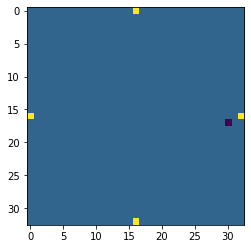

In [23]:
env.render()

([], <a list of 0 Text yticklabel objects>)

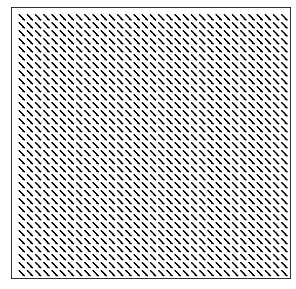

In [24]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action, value =[0.5,0.5],1
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])